<h1>Machine Learning Final Project</h1>
<h3>106000147 沈永聖 106061146 陳兆廷</h3>
<h2>Captcha Breaker using Residual CNN<h2>
<br>
<h2>動機：</h2>
<p>有位學弟參加了一個活動，需要每天登入投票來衝人數，而想省事又想幫助學弟的我就想到能用機器學習的方法，來解決這次的問題。<br>
    而最難的事情就是將登入頁面中的驗證碼解出，也就是本次Final要解決的問題。</p>
<br>
<h2>Dataset:</h2>
<p>在介紹前，我們先上網查了一下，查到 JasonLiTW 所做過的<a href="https://github.com/JasonLiTW/simple-railway-captcha-solver">臺鐵驗證碼CNN辨識器</a>，當中有提供生成出5碼驗證碼的python程式。如附錄所給的 captcha_gen.py 。</p>
<p>這個跑完以後，會先得到70000筆完全random的驗證碼，並有正確解答的csv檔，以供在train時可以正確label。</p>
<img src="images/1.png" style="width: 50%; display: inline;">
<img src="images/Screenshot_20200106_202902.png" style="width: 25%; display: inline;">
<p>接著，由於台鐵的驗證碼與我們所想要解碼的網站上之驗證碼有些小不同，因此又爬了一些（1200筆）目標網站的驗證碼。<br>
預計先在台鐵的70000筆資料上先train一次，再用我們想要的目標網站train一次。</p>

In [2]:
from time import sleep
import pandas as pd
import requests
import json
from PIL import Image
from base64 import b64encode,b64decode
from io import BytesIO
from bs4 import BeautifulSoup
import threading
from requests.adapters import HTTPAdapter

img_flag = False
token_flag = False
read_time = 20
delay = 0.1
s = requests.session()
s.mount('http://', HTTPAdapter(max_retries=30))
s.mount('https://', HTTPAdapter(max_retries=30))

while token_flag == False:
    try:
        r =s.get("https://youthdream.phdf.org.tw/member/login",timeout=read_time)              
        if r.status_code == 200:
            soup = BeautifulSoup(r.text, 'html.parser')
            _token = soup.select_one('input[name = "_token"]')['value']
            token_flag = True
        sleep(delay)
    except:
        None
## get cpatcha_url
_ = soup.select_one('a[id = "captcha"]').select_one('img')
captcha_url = _["src"]

for i in range(1000,1003):
    ## get captcha_img   
    img_flag = False
    while img_flag == False:
        try:
            cap_img =s.get(captcha_url,timeout=read_time)
            if cap_img.status_code == 200:
                image = Image.open(BytesIO(cap_img.content))
                image = image.convert('RGB')
                img_flag = True
                image.save('./data/captcha_original/jpg/'+str(i)+'.jpg')
        except:
            None

上面的步驟會將爬到的圖片存入captcha_original的資料夾內，但沒有答案（label）。<br>
所以我們只好手動label...<br>

1000


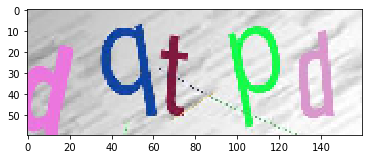

dqtpd


<Figure size 432x288 with 0 Axes>

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
#folder = "5_trans_set/"              
folder = "5_captc_rel/"                  #存在哪
filename_list = []
for i in range(1000,1001):           #這只是測試 寫一個就好
    print(i)
    im = Image.open('./data/captcha_original/jpg/'+str(i)+'.jpg') 
    im = im.resize((160,60))
    plt.imshow(im)
    plt.show()
    file_name = input()
    im.save('./data/'+folder+file_name+'.jpg')
    plt.clf()

因此總共有1000筆的目標網站Train data，及200筆的Test data。（手動label花了3～4小時）
<img src="images/Screenshot_20200106_221151.png" style="width: 50%; display: inline;">

<h4>總而言之，dataset有：</h4>
<ol>
  <li>70000筆 train data 五碼圖像驗證碼 genarate出來的</li>
  <li>1000筆 train data 目標網站的驗證碼 爬下來的自己label的</li>
  <li>200筆 test data 目標網站的驗證碼 爬下來的自己label的</li>
</ol> 

<h2>Method & Model </h2>
我們是引用<a href="https://github.com/JasonLiTW/simple-railway-captcha-solver">臺鐵驗證碼CNN辨識器</a>的model加以改良。<br>
第一個Model是單純將這個Model從tensorflow轉為PyTorch版本，在GPU上運行較快。<br>

In [12]:
# -*- coding: UTF-8 -*-
import torch.nn as nn
import torch
# CNN Model (2 conv layer)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Dropout(0.3))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Dropout(0.3))
        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Dropout(0.3))
        self.layer7= nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Dropout(0.3))
        self.out_layer1 = nn.Sequential(
            nn.Linear(2048,28),
            nn.Softmax(1)
           )
        self.out_layer2 = nn.Sequential(
            nn.Linear(2048,28),
            nn.Softmax(1)
           )
        self.out_layer3 = nn.Sequential(
            nn.Linear(2048,28),
            nn.Softmax(1)
           )
        self.out_layer4 = nn.Sequential(
            nn.Linear(2048,28),
            nn.Softmax(1)
           )
        self.out_layer5 = nn.Sequential(
            nn.Linear(2048,28),
            nn.Softmax(1)
           )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out1 = self.out_layer1(out)
        out2 = self.out_layer2(out)
        out3 = self.out_layer3(out)
        out4 = self.out_layer4(out)
        out5 = self.out_layer5(out)

        return out1,out2,out3,out4,out5

model = CNN()
if torch.cuda.is_available():
    model.cuda()

from torchsummary import summary
summary(model, input_size=(3, 60, 160))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 60, 160]             896
              ReLU-2          [-1, 32, 60, 160]               0
            Conv2d-3          [-1, 32, 58, 158]           9,248
              ReLU-4          [-1, 32, 58, 158]               0
       BatchNorm2d-5          [-1, 32, 58, 158]              64
         MaxPool2d-6           [-1, 32, 29, 79]               0
           Dropout-7           [-1, 32, 29, 79]               0
            Conv2d-8           [-1, 64, 29, 79]          18,496
              ReLU-9           [-1, 64, 29, 79]               0
           Conv2d-10           [-1, 64, 27, 77]          36,928
             ReLU-11           [-1, 64, 27, 77]               0
      BatchNorm2d-12           [-1, 64, 27, 77]             128
        MaxPool2d-13           [-1, 64, 13, 38]               0
          Dropout-14           [-1, 64,

<blockquote cite="https://github.com/JasonLiTW/simple-railway-captcha-solver">
透過數層由ReLU函數激發的Convolution Layer擷取特徵，並以2x2的Max pooling layer採樣減少計算量、BatchNormalization layer做標準化 及 Dropout Layer隨機捨棄一些神經元(避免overfitting)，最後用Flatten Layer來把資料降到1維，輸出到全連接層：5/6個34神經元的Softmax regression分類器。
</blockquote>
———引用自也是那位大大寫的model。<br><br>
<h4>Model Training</h4>
接著就來train我們的model。<br>
先train兩次，第一次用70000筆的generated dateset，將weight存好後，再train第二次，用1000筆我們目標網站的dataset。<br>

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='2, 3'
# -*- coding: UTF-8 -*-
import torch
import torch.nn as nn
from torch.autograd import Variable
import pytorch_dataset
from pytorch_model import CNN

# Hyper Parameters
num_epochs = 70
batch_size = 32
learning_rate = 0.001
use_cuda=True
def main():
    losses=[]
    device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
    cnn = CNN().to(device)
    cnn.train()
    print('init net')
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

    # Train the Model
    train_dataloader = pytorch_dataset.get_train_data_loader()
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_dataloader):
            images = Variable(images).to(device)
            labels1 = Variable(labels['label1'].float()).to(device)
            labels2 = Variable(labels['label2'].float()).to(device)
            labels3 = Variable(labels['label3'].float()).to(device)
            labels4 = Variable(labels['label4'].float()).to(device)
            labels5 = Variable(labels['label5'].float()).to(device)
            out1,out2,out3,out4, out5 = cnn(images)
            #out = cnn(images)

            # print(predict_labels.type)
            # print(labels.type)
            loss1 = criterion(out1, torch.max(labels1, 1)[1])
            loss2 = criterion(out2, torch.max(labels2, 1)[1])
            loss3 = criterion(out3, torch.max(labels3, 1)[1])
            loss4 = criterion(out4, torch.max(labels4, 1)[1])
            loss5 = criterion(out5, torch.max(labels5, 1)[1])
            loss = (loss1+loss2+loss3+loss4+loss5)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if (i+1) % 10 == 0:
                print("epoch:", epoch, "step:", i+1, "loss:", loss.item())
                losses.append( loss.item())
            if (i+1) % 100 == 0:
                torch.save(cnn.state_dict(), "./model.pkl")   #current is model.pkl
                print("save model")
        print("epoch:", epoch, "step:", i, "loss:", loss.item())
    torch.save(cnn.state_dict(), "./model.pkl")   #current is model.pkl
    print("save last model")
    df = pd.DataFrame(losses, columns = ["loss"])
    df.to_csv('CNN_loss.csv')

if __name__ == '__main__':
    main()

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import pytorch_dataset
from pytorch_model import CNN

# Hyper Parameters
num_epochs = 500
batch_size = 80
learning_rate = 0.001
use_cuda=True

def main():
    losses=[]
    device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
    cnn = CNN().to(device)
    cnn.train()
    cnn.load_state_dict(torch.load('model.pkl'))
    print('init net')
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
    step_size=100,
    gamma=0.5)
    # Train the Model
    train_dataloader = pytorch_dataset.get_transfer_data_loader()
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_dataloader):
            images = Variable(images).to(device)
            labels1 = Variable(labels['label1'].float()).to(device)
            labels2 = Variable(labels['label2'].float()).to(device)
            labels3 = Variable(labels['label3'].float()).to(device)
            labels4 = Variable(labels['label4'].float()).to(device)
            labels5 = Variable(labels['label5'].float()).to(device)
            out1,out2,out3,out4, out5 = cnn(images)
            #out = cnn(images)

            # print(predict_labels.type)
            # print(labels.type)
            loss1 = criterion(out1, torch.max(labels1, 1)[1])
            loss2 = criterion(out2, torch.max(labels2, 1)[1])
            loss3 = criterion(out3, torch.max(labels3, 1)[1])
            loss4 = criterion(out4, torch.max(labels4, 1)[1])
            loss5 = criterion(out5, torch.max(labels5, 1)[1])
            loss = (loss1+loss2+loss3+loss4+loss5)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if (i+1) % 10 == 0:
                print("epoch:", epoch, "step:", i, "loss:", loss.item())
                losses.append( loss.item())
            if (i+1) % 100 == 0:
                torch.save(cnn.state_dict(), "./model_trans.pkl")   #current is model.pkl
                print("save model")
        print("epoch:", epoch, "step:", i, "loss:", loss.item())
        optimizer.step()
    torch.save(cnn.state_dict(), "./model_trans.pkl")   #current is model.pkl
    print("save last model")
    df = pd.DataFrame(losses, columns = ["loss"])
    df.to_csv('CNN_train_loss.csv')
    
if __name__ == '__main__':
    main()

<h4>Model Testing</h4>
接下來就用我們200個的Testing dataset來看看我們Model Accuracy如何：

In [ ]:
# -*- coding: UTF-8 -*-
import numpy as np
import torch
from torch.autograd import Variable
#from visdom import Visdom # pip install Visdom
import pytorch_dataset
from pytorch_model import CNN

LETTERSTR = "2346789abcdefghjklmnpqrtuxyz"

def main():
    cnn = CNN()
    cnn.eval()
    cnn.load_state_dict(torch.load('model_trans.pkl'))
    print("load cnn net.")
    correct_num = 0
    step = 0.0
    predict_dataloader = pytorch_dataset.get_predict_data_loader()

    #vis = Visdom()
    for i, (images, labels) in enumerate(predict_dataloader):
        flag = False
        image = images
        vimage = Variable(image)
        out1,out2,out3,out4,out5 = cnn(vimage)
        labels1 = Variable(labels['label1'].float())
        labels2 = Variable(labels['label2'].float())
        labels3 = Variable(labels['label3'].float())
        labels4 = Variable(labels['label4'].float())
        labels5 = Variable(labels['label5'].float())
        l0 = LETTERSTR[torch.max(labels1, 1)[1]]
        l1 = LETTERSTR[torch.max(labels2, 1)[1]]
        l2 = LETTERSTR[torch.max(labels3, 1)[1]]
        l3 = LETTERSTR[torch.max(labels4, 1)[1]]
        l4 = LETTERSTR[torch.max(labels5, 1)[1]]
        
        c0 = LETTERSTR[torch.max(out1, 1)[1]]
        c1 = LETTERSTR[torch.max(out2, 1)[1]]
        c2 = LETTERSTR[torch.max(out3, 1)[1]]
        c3 = LETTERSTR[torch.max(out4, 1)[1]]
        c4 = LETTERSTR[torch.max(out5, 1)[1]]
        l = '%s%s%s%s%s' % (l0, l1, l2, l3, l4)
        c = '%s%s%s%s%s' % (c0, c1, c2, c3, c4)
        step += 1.0
        correct_num += 1
        
        if l0 != c0 or l1 != c1 or l2 != c2 or l3 != c3 or l4 != c4 :
            correct_num -= 1
            flag = True
        if flag :
            print("Wronse answer ! Predict: %s , Truth: %s "%(c,l))
        #vis.images(image, opts=dict(caption=c))
    accuracy = correct_num / step
    print("accuracy = {:.2%} ".format(accuracy))
        
if __name__ == '__main__':
    main()

可以看到：總體Accuracy為75％，但是由於有五個數字，因此個別數據的Accuracy應該分別為約94％，其實還不錯。<br>
且分析原因為：我們目標網站許多圖片看起來是i的全都是j，如下圖，因此會發生判斷錯誤的狀況（就算是人也會）。<br>
<img src="images/Screenshot_20200106_225611.png" style="width: 50%; display: inline;"><br>
接著我們想提高Accuracy，剛好學到Residual CNN能將每一個layer的feature回傳，讓Model更好，因此來改良我們的Model。<br>

In [13]:
# -*- coding: UTF-8 -*-
import torch.nn as nn
import torch
# CNN Model (2 conv layer)
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride),
            nn.BatchNorm2d(outchannel)
        )

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class RES(nn.Module):
    def __init__(self):
        super(RES, self).__init__()
        self.inchannel = 32
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            self.make_layer(ResidualBlock, 64,  1, stride=1),
            nn.MaxPool2d(2),
            nn.Dropout(0.3))

        self.layer3 = nn.Sequential(
            self.make_layer(ResidualBlock, 64,  1, stride=1),
            nn.MaxPool2d(2),
            nn.Dropout(0.3))

        self.layer4 = nn.Conv2d(64, 64, kernel_size=3, dilation = 2)
            
        self.layer5 = nn.Sequential(
            self.make_layer(ResidualBlock, 128,  1, stride=1),
            nn.MaxPool2d(2),
            nn.Dropout(0.3))

        self.layer6= nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Dropout(0.3))
        self.out_layer1 = nn.Sequential(
            nn.Linear(2048,28),
            nn.Softmax(1)
           )
        self.out_layer2 = nn.Sequential(
            nn.Linear(2048,28),
            nn.Softmax(1)
           )
        self.out_layer3 = nn.Sequential(
            nn.Linear(2048,28),
            nn.Softmax(1)
           )
        self.out_layer4 = nn.Sequential(
            nn.Linear(2048,28),
            nn.Softmax(1)
           )
        self.out_layer5 = nn.Sequential(
            nn.Linear(2048,28),
            nn.Softmax(1)
           )

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.layer1(x)
        #print(out.size(2),"test2")
        out = self.layer2(out)
        #print(out.size(2),"test2")
        out = self.layer3(out)
        #print(out.size(2),"test3")
        out = self.layer4(out)
        #print(out.size(2),"test4")
        out = self.layer5(out)
        #print(out.size(2),"test5")
        out = self.layer6(out)
        #print(out.size(0),"test6")
        out1 = self.out_layer1(out)
        out2 = self.out_layer2(out)
        out3 = self.out_layer3(out)
        out4 = self.out_layer4(out)
        out5 = self.out_layer5(out)
  
        return out1,out2,out3,out4,out5
        ##return out

model = RES()
if torch.cuda.is_available():
    model.cuda()

from torchsummary import summary
summary(model, input_size=(3, 60, 160))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 60, 160]             896
              ReLU-2          [-1, 32, 60, 160]               0
            Conv2d-3          [-1, 64, 60, 160]          18,496
       BatchNorm2d-4          [-1, 64, 60, 160]             128
              ReLU-5          [-1, 64, 60, 160]               0
            Conv2d-6          [-1, 64, 60, 160]          36,928
       BatchNorm2d-7          [-1, 64, 60, 160]             128
            Conv2d-8          [-1, 64, 60, 160]           2,112
       BatchNorm2d-9          [-1, 64, 60, 160]             128
    ResidualBlock-10          [-1, 64, 60, 160]               0
        MaxPool2d-11           [-1, 64, 30, 80]               0
          Dropout-12           [-1, 64, 30, 80]               0
           Conv2d-13           [-1, 64, 30, 80]          36,928
      BatchNorm2d-14           [-1, 64,

<h4>Validation</h4><br>
最後要實際運用在我們原本所想要的功能上：達成自動登入的效果。<br>
首先先將我們train好的model，也就是運用了Residual Network 的 CNN 放到Google engine上，以方便我們用python以request的方式上傳圖檔/回傳Prediction。<br>

In [ ]:
from selenium import webdriver
from time import sleep
from selenium.webdriver.chrome.options import Options
import pandas as pd
import requests
import json
from PIL import Image
from base64 import b64encode,b64decode
from io import BytesIO

df = pd.read_csv('account.csv')
opts = webdriver.ChromeOptions()
#opts.add_argument("--incognito")

ua = "Mozilla/5.0 (Windows NT 10.0; WOW64; rv:53.0) Gecko/20100101 Firefox/53.0"
opts.add_argument("user-agent={}".format(ua))
##opts.add_argument("--headless")       # define headless
driver = webdriver.Chrome(chrome_options=opts)
driver.set_window_size(1000, 800)
fail_list = []

for account, password in df.values :
    print("Voting with ",account," !")
    complete = False
    vote_flag = False
    count = 0
    login_flag = False
    while complete == False:
        try:
            driver.get("https://youthdream.phdf.org.tw/member/login")
            sleep(5)
            ## Login
            while login_flag == False :
                try:
                    ## get captcha picture
                    driver.execute_script("""
                        (function () {
                            var y = 0;
                            var step = 100;
                            window.scroll(0, 9999);
                        })();
                    """)
                    
                    captcha = driver.find_element_by_id('captcha')
                    offset = 1302
                    driver.save_screenshot('./screen_shot/captcha.png')
                    left = captcha.location['x']+1
                    top = captcha.location['y']+1-offset
                    right = captcha.location['x'] + captcha.size['width']
                    bottom = captcha.location['y'] + captcha.size['height']-offset
                    im = Image.open('./screen_shot/captcha.png')
                    im = im.crop((left, top, right, bottom))
                    rgb_im = im.convert('RGB')
                    re = rgb_im.resize((160,60))
                    re.save('./screen_shot/captcha/captcha.jpg')
                    sleep(2)
                    
                    ## break captcha
                    
                    ENCODING = 'utf-8'
                    output_buffer = BytesIO()
                    re.save(output_buffer, format='JPEG')
                    byte_data = output_buffer.getvalue()
                    base64_bytes = b64encode(byte_data)
                    base64_string = base64_bytes.decode(ENCODING)
                    data = {"Captcha":base64_string}  # img是ndarray，無法直接用base64編碼，否則會報錯
                    data = json.dumps(data)
                    r = requests.post(" https://captchabreak-261615.appspot.com/Captcha", data=data)
                    c = json.loads(r.text)["Captcha"]
                    
                    ##login
                    driver.find_element_by_name("email").clear()
                    driver.find_element_by_name("email").send_keys(account)
                    driver.find_element_by_name("password").clear()
                    driver.find_element_by_name("password").send_keys(password)
                    driver.find_element_by_name("captcha").clear()
                    driver.find_element_by_name("captcha").send_keys(c)
                    driver.find_element_by_xpath("//button[@class='button-5']").click()
                    sleep(2)
                except:
                    try :
                        element = driver.find_element_by_name("email")
                    except:
                        print("sign in success!")
                    login_flag = True
                try :
                    element = driver.find_element_by_name("email")
                except:
                    print("sign in success!")
                    login_flag = True

            
            ## logout google 
            driver.get("https://youthdream.phdf.org.tw/member/logout")
            sleep(2)
            complete = True
            sleep(5)
        except:
            count += 1
            if count == 5 :
                complete = True
                fail_list.append(account)
            else:
                print(account,"Try again")
            sleep(10) 
            driver.get("https://youthdream.phdf.org.tw/member/logout")
            sleep(2)
        

print("Complete")
sleep(5)
driver.close()